In [137]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### CS Misclassification Prediction

In [138]:
method_transform = {
    'Vanilla': 'Vanilla',
    'Entropy': 'Entropy',
    'ModelWithTemperature': 'Temp Scale',
    'ModelActivateDropout': 'MC-Dropout',
    'Mutation': 'mMutant',
    'PVScore': 'Dissector',
}
task_transform = {
    'CodeSummary_Module': 'Method name prediction',
    'CodeCompletion_Module': 'Code completion',
}
shift_intensity_names = {
    'Validation': 'BigCloneEval (in-dist.)',
    'Shifted': 'Ruoyiplus (shifted)',
}

dir = '../Uncertainty_Eval/'
task = 'CodeSummary_Module'
shift = 'case_study'
csmodels = ['code2vec', 'coderoberta', 'graphcodebert']
ccmodels = ['lstm', 'codebert', 'codegpt']

record = []
if task == 'CodeSummary_Module':
    models = csmodels
else:
    models = ccmodels
for model in models:
    res = torch.load(os.path.join(dir, shift, model, task, 'uncertainty_eval.res'))
    for ue, outputs in res.items():
        auc_res = outputs['AUC']
        aupr_res = outputs['AUPR']
        brier_res = outputs['Brier']
        if ue in ['Mutation', 'PVScore']:
            auc_ins = {
                'Method': method_transform[ue],
                'Metric': 'AUC',
                'Shift': shift,
                'Task': task_transform[task],
                'Model': model,
                'Validation': auc_res[0]['val']*100,
                'Shifted': auc_res[0]['test']*100,
            }
            aupr_ins = {
                'Method': method_transform[ue],
                'Metric': 'AUPR',
                'Shift': shift,
                'Task': task_transform[task],
                'Model': model,
                'Validation': aupr_res[0]['val']*100,
                'Shifted': aupr_res[0]['test']*100,
            }
            brier_ins = {
                'Method': method_transform[ue],
                'Metric': 'Brier',
                'Shift': shift,
                'Task': task_transform[task],
                'Model': model,
                'Validation': brier_res[0]['val']*100,
                'Shifted': brier_res[0]['test']*100,
            }
        else:
            auc_ins = {
                'Method': method_transform[ue],
                'Metric': 'AUC',
                'Shift': shift,
                'Task': task_transform[task],
                'Model': model,
                'Validation': auc_res['val']*100,
                'Shifted': auc_res['test']*100,
            }
            aupr_ins = {
                'Method': method_transform[ue],
                'Metric': 'AUPR',
                'Shift': shift,
                'Task': task_transform[task],
                'Model': model,
                'Validation': aupr_res['val']*100,
                'Shifted': aupr_res['test']*100,
            }
            brier_ins = {
                'Method': method_transform[ue],
                'Metric': 'Brier',
                'Shift': shift,
                'Task': task_transform[task],
                'Model': model,
                'Validation': brier_res['val']*100,
                'Shifted': brier_res['test']*100,
            }
        record.append(auc_ins)
        record.append(aupr_ins)
        record.append(brier_ins)
    
cs_df = pd.DataFrame(record)
cs_df_auc = cs_df[cs_df['Metric'] == 'AUC']
cs_df_aupr = cs_df[cs_df['Metric'] == 'AUPR']
cs_df_brier = cs_df[cs_df['Metric'] == 'Brier']

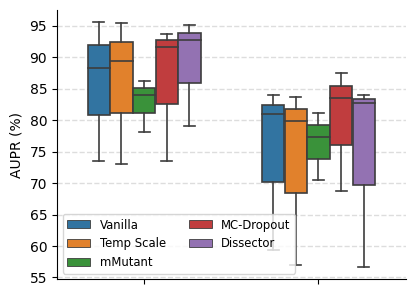

In [146]:
# Reshape the data using melt function
data_melt = pd.melt(
    cs_df_aupr, 
    id_vars=['Method', 'Metric', 'Shift', 'Task', 'Model'],
    value_vars=['Validation', 'Shifted'],
    var_name='Shift_Intensity', 
    value_name='AUPR',
)
data_melt['Shift_Intensity'] = data_melt['Shift_Intensity'].map(shift_intensity_names)

# Plot boxplot using seaborn
method_order = ['Vanilla', 'Temp Scale', 'mMutant', 'MC-Dropout', 'Dissector']
plt.figure(figsize=(4.5, 3.5))
plt.grid(True, color='#DDDDDD', linestyle='--', linewidth=1)
ax = sns.boxplot(
    data=data_melt, 
    x='Shift_Intensity', 
    y='AUPR', 
    hue='Method', 
    hue_order=method_order, 
    width=0.65,
    linewidth=1.2,
)
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(ncols=2, fontsize='small')
# set the y-axis tick labels as integers
ax.set_xticklabels(['']*2)
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
plt.title('')
plt.xlabel('')
plt.ylabel('AUPR (%)')
plt.savefig('../Figure/case_cs_aupr.pdf', bbox_inches='tight')
plt.show()

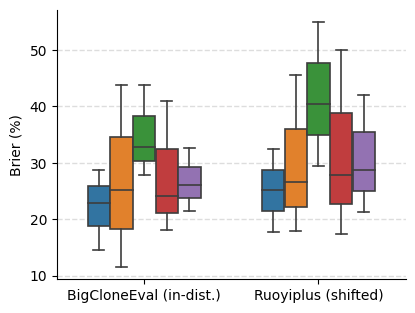

In [140]:
cs_df_brier = pd.DataFrame({
    'Method': ['Temp Scale', 'Entropy', 'mMutant', 'Vanilla', 'MC-Dropout', 'Dissector'] * 3,
    'Metric': ['Brier'] * 6 * 3,
    'Shift': ['case_study'] * 6 * 3,
    'Task': ['Method name prediction'] * 6 * 3,
    'Model': ['code2vec'] * 6 + ['coderoberta'] * 6 + ['graphcodebert'] * 6,
    'Validation': [25.181279, 24.142796, 43.765028, 22.956105, 40.914721, 32.623968,                    
                   43.848295, 35.886321, 27.819711, 28.747549, 18.056281, 21.447430,                    
                   11.520990, 19.534792, 32.822975, 14.601129, 24.137399, 26.023761],
    'Shifted': [26.518048, 29.522968, 54.968802, 25.150621, 49.947451, 42.105448,                 
                45.644252, 41.705217, 29.483023, 32.481647, 17.450679, 21.283575,                 
                17.942355, 23.583005, 40.412548, 17.654084, 27.806263, 28.682076],
})
# Reshape the data using melt function
data_melt = pd.melt(
    cs_df_brier, 
    id_vars=['Method', 'Metric', 'Shift', 'Task', 'Model'],
    value_vars=['Validation', 'Shifted'],
    var_name='Shift_Intensity', 
    value_name='Brier',
)
data_melt['Shift_Intensity'] = data_melt['Shift_Intensity'].map(shift_intensity_names)

# Plot boxplot using seaborn
method_order = ['Vanilla', 'Temp Scale', 'mMutant', 'MC-Dropout', 'Dissector']
plt.figure(figsize=(4.5, 3.5))
plt.grid(True, color='#DDDDDD', linestyle='--', linewidth=1)
ax = sns.boxplot(
    data=data_melt, 
    x='Shift_Intensity', 
    y='Brier', 
    hue='Method', 
    hue_order=method_order, 
    width=0.65,
    linewidth=1.2,
)
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.legend(ncols=2, fontsize='small')
ax.legend([],[], frameon=False)
# set the y-axis tick labels as integers
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
plt.title('')
plt.xlabel('')
plt.ylabel('Brier (%)')
plt.savefig('../Figure/case_cs_brier.pdf', bbox_inches='tight')
plt.show()

### CC Misclassification Prediction

In [141]:
dir = '../Uncertainty_Eval/'
task = 'CodeCompletion_Module'
shift = 'case_study'

record = []
if task == 'CodeSummary_Module':
    models = csmodels
else:
    models = ccmodels
for model in models:
    res = torch.load(os.path.join(dir, shift, model, task, 'uncertainty_eval.res'))
    for ue, outputs in res.items():
        auc_res = outputs['AUC']
        aupr_res = outputs['AUPR']
        brier_res = outputs['Brier']
        if ue in ['Mutation', 'PVScore']:
            auc_ins = {
                'Method': method_transform[ue],
                'Metric': 'AUC',
                'Shift': shift,
                'Task': task_transform[task],
                'Model': model,
                'Validation': auc_res[0]['val']*100,
                'Shifted': auc_res[0]['test']*100,
            }
            aupr_ins = {
                'Method': method_transform[ue],
                'Metric': 'AUPR',
                'Shift': shift,
                'Task': task_transform[task],
                'Model': model,
                'Validation': aupr_res[0]['val']*100,
                'Shifted': aupr_res[0]['test']*100,
            }
            brier_ins = {
                'Method': method_transform[ue],
                'Metric': 'Brier',
                'Shift': shift,
                'Task': task_transform[task],
                'Model': model,
                'Validation': brier_res[0]['val']*100,
                'Shifted': brier_res[0]['test']*100,
            }
        else:
            auc_ins = {
                'Method': method_transform[ue],
                'Metric': 'AUC',
                'Shift': shift,
                'Task': task_transform[task],
                'Model': model,
                'Validation': auc_res['val']*100,
                'Shifted': auc_res['test']*100,
            }
            aupr_ins = {
                'Method': method_transform[ue],
                'Metric': 'AUPR',
                'Shift': shift,
                'Task': task_transform[task],
                'Model': model,
                'Validation': aupr_res['val']*100,
                'Shifted': aupr_res['test']*100,
            }
            brier_ins = {
                'Method': method_transform[ue],
                'Metric': 'Brier',
                'Shift': shift,
                'Task': task_transform[task],
                'Model': model,
                'Validation': brier_res['val']*100,
                'Shifted': brier_res['test']*100,
            }
        record.append(auc_ins)
        record.append(aupr_ins)
        record.append(brier_ins)
    
cc_df = pd.DataFrame(record)
cc_df_auc = cc_df[cc_df['Metric'] == 'AUC']
cc_df_aupr = cc_df[cc_df['Metric'] == 'AUPR']
cc_df_brier = cc_df[cc_df['Metric'] == 'Brier']

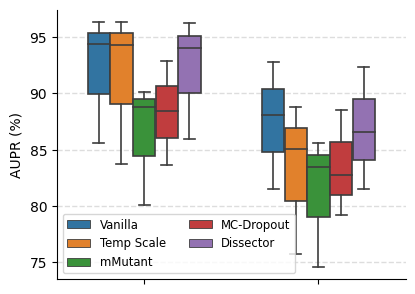

In [147]:
cc_df_aupr = pd.DataFrame({
    'Method': ['Temp Scale', 'Entropy', 'mMutant', 'Vanilla', 'MC-Dropout', 'Dissector'] * 3,
    'Metric': ['AUPR'] * 6 * 3,
    'Shift': ['case_study'] * 6 * 3,
    'Task': ['Code completion'] * 6 * 3,
    'Model': ['lstm'] * 6 + ['codebert'] * 6 + ['codegpt'] * 6,
    'Validation': [94.310886, 96.028657, 88.82424, 94.380813, 88.437638, 94.057344, 
                83.77862, 89.611762, 80.073376, 85.582611, 83.681013, 85.99671, 
                96.360327, 95.96581, 90.118653, 96.323769, 92.859405, 96.230995],
    'Shifted': [85.105414, 84.586621, 83.460103, 88.108229, 82.741485, 86.616888,
                75.779079, 77.591379, 74.595693, 81.548549, 79.200687, 81.507742,
                88.787705, 85.332301, 85.623871, 92.764199, 88.550278, 92.320614],
})
# Reshape the data using melt function
data_melt = pd.melt(
    cc_df_aupr, 
    id_vars=['Method', 'Metric', 'Shift', 'Task', 'Model'],
    value_vars=['Validation', 'Shifted'],
    var_name='Shift_Intensity', 
    value_name='AUPR',
)
data_melt['Shift_Intensity'] = data_melt['Shift_Intensity'].map(shift_intensity_names)

# Plot boxplot using seaborn
method_order = ['Vanilla', 'Temp Scale', 'mMutant', 'MC-Dropout', 'Dissector']
plt.figure(figsize=(4.5, 3.5))
plt.grid(True, color='#DDDDDD', linestyle='--', linewidth=1)
ax = sns.boxplot(
    data=data_melt, 
    x='Shift_Intensity', 
    y='AUPR', 
    hue='Method', 
    hue_order=method_order, 
    width=0.65,
    linewidth=1.2,
)
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(ncols=2, fontsize='small')
# set the y-axis tick labels as integers
ax.set_xticklabels(['']*2)
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
plt.title('')
plt.xlabel('')
plt.ylabel('AUPR (%)')
plt.savefig('../Figure/case_cc_aupr.pdf', bbox_inches='tight')
plt.show()

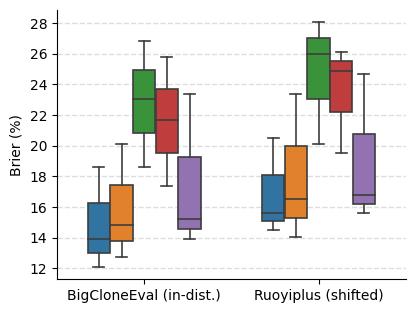

In [143]:
cc_df_brier = pd.DataFrame({
    'Method': ['Temp Scale', 'Entropy', 'mMutant', 'Vanilla', 'MC-Dropout', 'Dissector'] * 3,
    'Metric': ['Brier'] * 6 * 3,
    'Shift': ['case_study'] * 6 * 3,
    'Task': ['Code completion'] * 6 * 3,
    'Model': ['lstm'] * 6 + ['codebert'] * 6 + ['codegpt'] * 6,
    'Validation': [12.759712, 12.413041, 18.571994, 12.076992, 21.637525, 15.188627,            
                   20.101890, 17.313177, 26.836636, 18.594386, 25.784081, 23.334789,            
                   14.808706, 13.378044, 23.013538, 13.900978, 17.355761, 13.899201],
    'Shifted': [14.024493, 14.023432, 20.116393, 14.496614, 26.135616, 16.802571,               
                23.364859, 18.460662, 28.061970, 20.512377, 24.899068, 24.668945,               
                16.520850, 14.196060, 25.990188, 15.625420, 19.497597, 15.604441],
})
# Reshape the data using melt function
data_melt = pd.melt(
    cc_df_brier, 
    id_vars=['Method', 'Metric', 'Shift', 'Task', 'Model'],
    value_vars=['Validation', 'Shifted'],
    var_name='Shift_Intensity', 
    value_name='Brier',
)
data_melt['Shift_Intensity'] = data_melt['Shift_Intensity'].map(shift_intensity_names)

# Plot boxplot using seaborn
method_order = ['Vanilla', 'Temp Scale', 'mMutant', 'MC-Dropout', 'Dissector']
plt.figure(figsize=(4.5, 3.5))
plt.grid(True, color='#DDDDDD', linestyle='--', linewidth=1)
ax = sns.boxplot(
    data=data_melt, 
    x='Shift_Intensity', 
    y='Brier', 
    hue='Method', 
    hue_order=method_order, 
    width=0.65,
    linewidth=1.2,
)
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.legend(ncols=2, fontsize='small')
ax.legend([],[], frameon=False)
# set the y-axis tick labels as integers
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
plt.title('')
plt.xlabel('')
plt.ylabel('Brier (%)')
plt.savefig('../Figure/case_cc_brier.pdf', bbox_inches='tight')
plt.show()